# 셀 A 최초 1회
**목적** Opnebot과 Colab 환경 맞추기
> Colab(Py3.12)과 맞는 TF/Numpy 조합 설치



In [1]:
# [한글] Colab(Py3.12)과 호환되는 기본 스택 설치
# - TF 2.20.0 + NumPy 2.0.x 조합
# - ml-dtypes는 TF가 자동으로(>=0.5.1) 설치하므로 지정하지 않습니다.

!pip uninstall -y jax jaxlib chex optax flax \
  tensorflow-text tensorflow-decision-forests tf-keras tensorstore \
  orbax-checkpoint tensorflow-hub dopamine-rl albumentations albucore \
  pymc pytensor bigframes ydf -qq

!pip install -q --upgrade --force-reinstall tensorflow==2.20.0 numpy==2.0.2

# (선택) 경고 줄이기: protobuf/pillow/requests/jedi 버전 맞춤
!pip install -q "protobuf<6,>=5.28.0" "pillow<12.0" "requests==2.32.4" "jedi>=0.16"

# 설치 확인(ml_dtypes는 0.5.1+면 정상)
!pip show ml-dtypes | sed -n '1,5p'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 845.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 153.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 135.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 122.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/6

**실행 후**
> 세션 다시 시작(런타임 → 세션 다시 시작)

# 셀 B - 버전/GPU 확인
목적 : 설치 검증

In [1]:
# [한글] 설치된 버전 및 GPU 인식 확인
import numpy as np, tensorflow as tf
print("NumPy:", np.__version__)       # 기대: 2.0.x
print("TensorFlow:", tf.__version__)  # 기대: 2.20.0
print("GPU:", tf.test.gpu_device_name() or "CPU 사용")


NumPy: 2.0.2
TensorFlow: 2.20.0
GPU: /device:GPU:0


# 셀 C - 기본 임포트/로그 억제
목적 : 불필요한 로그 줄이고 기본 도구 준비

In [3]:
# [한글] 학습에 자주 쓰는 라이브러리 임포트 + 로그 억제
from __future__ import absolute_import, division, print_function, unicode_literals
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time, os
import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # TF Info/Warning 숨김
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"  # (Mac용 워크어라운드, 넣어도 무해)

# 셀 D - Google Drive 마운트
목적 : 드라이브 연결

In [4]:
# [한글] Google Drive 마운트 (권한 승인 필요)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**특이사항** : Opnebot에서 학습 시킨 데이터 ZIP 파일은
마운트가 끝나면, Drive의 루트에 OpenBotData 같은 새 폴더를 만들고, PC에서 ZIP 두 개를 직접 Drive로 업로드! (드라이브 웹 UI나 Colab 파일창 상단 업로드 버튼 사용)

# 셀 E - ZIP 해제(충돌 방지 분리 폴더)
목적 : ZIP을 /content/data/run1, run2에 해제

In [6]:
# [한글] 같은 이름 파일 덮어쓰기 방지용으로 각각 폴더에 풀기
!rm -rf /content/data && mkdir -p /content/data/run1 /content/data/run2
!unzip -oq "/content/drive/MyDrive/OpenBotData/20251031_145012.zip" -d /content/data/run1
!unzip -oq "/content/drive/MyDrive/OpenBotData/20251031_145241.zip" -d /content/data/run2
!ls -al /content/data

total 16
drwxr-xr-x 4 root root 4096 Oct 31 12:01 .
drwxr-xr-x 1 root root 4096 Oct 31 12:01 ..
drwxr-xr-x 4 root root 4096 Oct 31 12:01 run1
drwxr-xr-x 4 root root 4096 Oct 31 12:01 run2


# 셀 F - 저장소 받기 + 파이썬 경로 추가
목적 : OpenBot 코드를 가져오고, 파이썬이 찾을 수 있게 경로 추가

In [7]:
# [한글] OpenBot 저장소가 없으면 clone, 있으면 최신으로 갱신
import os, sys, importlib, subprocess, shlex

if not os.path.isdir("/content/OpenBot/.git"):
    !git clone https://github.com/Jinhan0603/OpenBot.git /content/OpenBot
else:
    # (선택) 최신 갱신
    !git -C /content/OpenBot pull --ff-only

# 파이썬 모듈 경로 추가
if "/content/OpenBot/policy" not in sys.path:
    sys.path.insert(0, "/content/OpenBot/policy")
importlib.invalidate_caches()

# openbot 패키지 폴더 존재 확인
assert os.path.isdir("/content/OpenBot/policy/openbot"), "openbot 패키지가 보이지 않습니다."
print("openbot path OK")


Cloning into '/content/OpenBot'...
remote: Enumerating objects: 15335, done.
remote: Counting objects: 100% (587/587), done.
remote: Compressing objects: 100% (394/394), done.
remote: Total 15335 (delta 304), reused 193 (delta 193), pack-reused 14748 (from 3)
Receiving objects: 100% (15335/15335), 237.33 MiB | 38.71 MiB/s, done.
Resolving deltas: 100% (8471/8471), done.
Updating files: 100% (2153/2153), done.
openbot path OK


# 셀 G - OpenBot 임포트 확인
목적 : 실제로 import가 되는지 확인

In [8]:
# [한글] OpenBot 모듈 임포트 테스트
from openbot import dataloader, data_augmentation, utils, train
print("openbot import OK")

Default GPU Device:/device:GPU:0
openbot import OK


# 셀 H - OpenBot이 기대하는 폴더 구조로 복사
목적 : 노트북/코드가 찾는 표준 경로에 데이터 배치

In [9]:
# [한글] OpenBot 표준 데이터 경로에 복사
!mkdir -p /content/OpenBot/policy/dataset/train_data/my_dataset_1
!mkdir -p /content/OpenBot/policy/dataset/test_data/my_dataset_2
!cp -r /content/data/run1 /content/OpenBot/policy/dataset/train_data/my_dataset_1/
!cp -r /content/data/run2 /content/OpenBot/policy/dataset/test_data/my_dataset_2/

# 확인
!find /content/OpenBot/policy/dataset -maxdepth 3 -type d -print


/content/OpenBot/policy/dataset
/content/OpenBot/policy/dataset/train_data
/content/OpenBot/policy/dataset/train_data/my_dataset_1
/content/OpenBot/policy/dataset/train_data/my_dataset_1/run1
/content/OpenBot/policy/dataset/test_data
/content/OpenBot/policy/dataset/test_data/my_dataset_2
/content/OpenBot/policy/dataset/test_data/my_dataset_2/run2
/content/OpenBot/policy/dataset/uploaded


# 셀 D1 — 데이터 구조 진단(실제 세션 탐색)
목적: 현재 어떤 폴더가 “세션”으로 인식되는지, 필요한 파일이 있는지 즉시 확인

In [10]:
# [한글] 세션 후보 자동 탐색 + 핵심 파일 유무 점검
import os, glob, textwrap

def find_sessions(root):
    cand=[]
    for r, d, f in os.walk(root):
        if os.path.isdir(os.path.join(r,'images')) and os.path.isdir(os.path.join(r,'sensor_data')):
            cand.append(r)
    return sorted(cand)

train_root = "/content/OpenBot/policy/dataset/train_data"
test_root  = "/content/OpenBot/policy/dataset/test_data"

train_sessions = find_sessions(train_root)
test_sessions  = find_sessions(test_root)

print("[세션 탐색] train:", len(train_sessions), "개")
for s in train_sessions[:5]:
    print(" -", s)
print("[세션 탐색] test :", len(test_sessions), "개")
for s in test_sessions[:5]:
    print(" -", s)

# 각 세션에서 필수 파일 유무 확인(autopilot 기준)
must = ["rgbFrames.txt","ctrlLog.txt","indicatorLog.txt"]
def check_sensor_files(sess):
    sd = os.path.join(sess,"sensor_data")
    miss=[m for m in must if not os.path.isfile(os.path.join(sd,m))]
    return sd, miss

for title, sess_list in [("[점검] train",train_sessions),("[점검] test",test_sessions)]:
    print(title)
    for s in sess_list[:5]:
        sd, miss = check_sensor_files(s)
        print(" -", s, "필수 누락:", miss if miss else "없음")


[세션 탐색] train: 1 개
 - /content/OpenBot/policy/dataset/train_data/my_dataset_1/run1
[세션 탐색] test : 1 개
 - /content/OpenBot/policy/dataset/test_data/my_dataset_2/run2
[점검] train
 - /content/OpenBot/policy/dataset/train_data/my_dataset_1/run1 필수 누락: 없음
[점검] test
 - /content/OpenBot/policy/dataset/test_data/my_dataset_2/run2 필수 누락: 없음


# 셀 D2 — 자동 복구(세션 재배치 + 파일명 정규화 + _crop 프록시 생성)
목적: 현재 ZIP 풀어둔 위치에서 “세션으로 인식되는 폴더”를 찾아 올바른 위치로 복사하고, 로그 파일명을 OpenBot이 기대하는 이름으로 맞추며, *_crop.jpeg 프록시도 생성합니다.

In [11]:
# [한글] 세션 자동 복구: 복사/정규화/프록시 생성
import os, shutil, pathlib

# 1) 원본이 있는 위치(처음 unzip 했던 곳)에서 세션 후보를 찾습니다.
src_roots = ["/content/data/run1","/content/data/run2","/content/data"]
def scan_src_sessions(src_root):
    out=[]
    for r, d, f in os.walk(src_root):
        if os.path.isdir(os.path.join(r,'images')) and os.path.isdir(os.path.join(r,'sensor_data')):
            out.append(r)
    return sorted(set(out))

candidates=[]
for rt in src_roots:
    if os.path.isdir(rt):
        candidates.extend(scan_src_sessions(rt))
candidates=sorted(set(candidates))
print("[원본에서 찾은 세션]", len(candidates), "개")
for s in candidates[:5]: print(" -", s)

# 2) 데이터셋 목적지(학습이 읽는 위치)로 복사(이미 있으면 건너뜀)
dst_train_ds = "/content/OpenBot/policy/dataset/train_data/my_dataset_1"
dst_test_ds  = "/content/OpenBot/policy/dataset/test_data/my_dataset_2"
os.makedirs(dst_train_ds, exist_ok=True)
os.makedirs(dst_test_ds,  exist_ok=True)

# 절반은 train, 절반은 test로 보냅니다(간단 분할)
half = len(candidates)//2 or len(candidates)
train_pick = candidates[:half]
test_pick  = candidates[half:]

def safe_copy(src, dst_parent):
    name = pathlib.Path(src).name
    dst  = os.path.join(dst_parent, name)
    i=1
    while os.path.exists(dst):
        i+=1
        dst = os.path.join(dst_parent, f"{name}_{i}")
    shutil.copytree(src, dst)
    return dst

copied_train = [safe_copy(s, dst_train_ds) for s in train_pick]
copied_test  = [safe_copy(s, dst_test_ds)  for s in test_pick]
print("[복사됨] train:", len(copied_train), " test:", len(copied_test))

# 3) 로그 파일 이름 정규화(autopilot 기준으로 가장 흔한 변형을 기대 이름으로 맞춤)
rename_map = {
    "rgbframes.txt":"rgbFrames.txt",
    "rgb_frames.txt":"rgbFrames.txt",
    "ctrllog.txt":"ctrlLog.txt",
    "controlLog.txt":"ctrlLog.txt",
    "indicatorlog.txt":"indicatorLog.txt",
    "indicator_log.txt":"indicatorLog.txt",
}
def normalize_logs(sess_root):
    sd = os.path.join(sess_root,"sensor_data")
    for f in os.listdir(sd):
        lf = f.lower()
        if lf in rename_map and not os.path.isfile(os.path.join(sd, rename_map[lf])):
            os.rename(os.path.join(sd,f), os.path.join(sd, rename_map[lf]))

for s in copied_train + copied_test:
    sd = os.path.join(s,"sensor_data")
    if os.path.isdir(sd):
        normalize_logs(s)

# 4) *_crop.jpeg 프록시 생성(확장자/이름 변형 모두 대응)
def ensure_crop_proxies(session_root):
    img_dir = os.path.join(session_root,"images")
    for f in os.listdir(img_dir):
        p = pathlib.Path(img_dir)/f
        if p.suffix.lower() not in [".jpeg",".jpg",".png"]:
            continue
        stem = p.stem  # 'xxx' or 'xxx.jpg'(확장 없는 경우 대비)
        # a) xxx_crop.jpeg
        tgt1 = p.with_name(stem + "_crop.jpeg")
        # b) xxx{ext}_crop.jpeg (로그가 'xxx.jpg'처럼 확장자 포함으로 기록된 경우)
        tgt2 = p.with_name(stem + p.suffix + "_crop.jpeg")
        for tgt in [tgt1, tgt2]:
            if not tgt.exists():
                try: os.symlink(p, tgt)
                except Exception:
                    shutil.copy2(str(p), str(tgt))

for s in copied_train + copied_test:
    img = os.path.join(s,"images")
    if os.path.isdir(img):
        ensure_crop_proxies(s)

print("자동 복구 완료")


[원본에서 찾은 세션] 2 개
 - /content/data/run1
 - /content/data/run2
[복사됨] train: 1  test: 1
자동 복구 완료


# 셀 I - 데이터 경로 지정  ❌
> 노트북 기본 예시는 dataset_dir = "dataset"(상대경로)인데, Colab의 작업 디렉터리에 따라 빗나갈 수 있어요. openbot이 가지고 있는 절대경로를 쓰면 이후 단계와 정확히 일치합니다.



In [8]:
# [한글] 학습에 사용할 데이터셋 경로 지정
# - openbot 패키지의 기본 경로를 그대로 사용하면 이후 단계와 경로가 일치합니다.
import os
import openbot as ob

dataset_dir = ob.dataset_dir                     # /content/OpenBot/policy/dataset
dataset_name = "openbot"                         # 표기용 이름
train_data_dir = os.path.join(dataset_dir, "train_data")
test_data_dir  = os.path.join(dataset_dir, "test_data")

print("dataset_dir   :", dataset_dir)
print("train_data_dir:", train_data_dir)
print("test_data_dir :", test_data_dir)
assert os.path.isdir(train_data_dir), "train_data_dir 폴더가 없습니다."
assert os.path.isdir(test_data_dir),  "test_data_dir 폴더가 없습니다."


dataset_dir   : /content/OpenBot/policy/dataset
train_data_dir: /content/OpenBot/policy/dataset/train_data
test_data_dir : /content/OpenBot/policy/dataset/test_data


# 셀 J - 폴더 구조 점검 및 자동 정리(필요 시)  ❌


> ZIP을 run1, run2 같은 중간 폴더에 풀면 세션 폴더가 한 단계 더 깊어질 수 있어요. 이 셀은 그런 경우를 자동으로 올바른 깊이로 이동시켜 줍니다.



In [9]:
# [한글] 데이터 구조가 올바른지 검사하고, 한 단계 더 깊게 들어간 경우 자동으로 평탄화합니다.
# 기대 구조:
#  train_data/
#    └─ my_dataset_1/
#         └─ <각 세션>/ (images/, sensor_data/)
#  test_data/
#    └─ my_dataset_2/
#         └─ <각 세션>/ (images/, sensor_data/)
from pathlib import Path
import shutil

def ensure_flat(ds_root: Path):
  for ds in ds_root.iterdir():
    if not ds.is_dir():
      continue
    # 올바른 경우: ds/<session>/sensor_data 존재
    ok = list(ds.glob("*/sensor_data"))
    if ok:
      continue
    # 잘못된 경우(한 단계 더 깊음): ds/*/*/sensor_data -> 세션 폴더를 한 단계 위로 이동
    deep = list(ds.glob("*/*/sensor_data"))
    for sd in deep:
      session = sd.parent
      target_parent = ds
      target = target_parent / session.name
      if target.exists():
        i = 1
        while (target_parent / f"{session.name}_{i}").exists():
          i += 1
        target = target_parent / f"{session.name}_{i}"
      print(f"[move] {session} -> {target_parent}")
      shutil.move(str(session), str(target))

ensure_flat(Path(train_data_dir))
ensure_flat(Path(test_data_dir))

# 요약: 세션/이미지 개수
def count_sessions(root: str) -> int:
  return sum(1 for p in Path(root).glob("*/") if p.is_dir())
def count_imgs(root: str) -> int:
  return len(list(Path(root).glob("*/*/images/*")))

print("train sessions:", count_sessions(train_data_dir), "images:", count_imgs(train_data_dir))
print("test  sessions:", count_sessions(test_data_dir),  "images:", count_imgs(test_data_dir))


train sessions: 1 images: 1897
test  sessions: 1 images: 2003


# 셀 K - 샘플 경로 빠른 확인  ❌
> 세션/이미지 경로가 기대대로 보이면 다음 섹션(‘Hyperparameters’)로 넘어가면 됩니다.

In [10]:
# [한글] 샘플 이미지 경로를 몇 개 출력해 구조가 맞는지 빠르게 확인합니다.
from pathlib import Path

sample_train = list(Path(train_data_dir).glob("*/*/images/*"))[:3]
sample_test  = list(Path(test_data_dir).glob("*/*/images/*"))[:3]

print("sample train:", [str(p) for p in sample_train] or "없음")
print("sample test :", [str(p) for p in sample_test]  or "없음")


sample train: ['/content/OpenBot/policy/dataset/train_data/my_dataset_1/run1/images/7851_crop.jpeg', '/content/OpenBot/policy/dataset/train_data/my_dataset_1/run1/images/7840_crop.jpeg', '/content/OpenBot/policy/dataset/train_data/my_dataset_1/run1/images/8209_crop.jpeg']
sample test : ['/content/OpenBot/policy/dataset/test_data/my_dataset_2/run2/images/1799_crop.jpeg', '/content/OpenBot/policy/dataset/test_data/my_dataset_2/run2/images/506_crop.jpeg', '/content/OpenBot/policy/dataset/test_data/my_dataset_2/run2/images/2346_crop.jpeg']


# 셀 L - Hyperparameters 설정  
목적 : 학습에 사용할 하이퍼파라미터(모델/정책/배치/에폭 등) 지정

In [14]:
# [한글] 학습 하이퍼파라미터 설정
# - 처음엔 가볍게 동작 확인이 목적이므로 에폭/배치를 작게 둡니다.
# - POLICY가 "autopilot"이면 IS_CROP=False, "point_goal_nav"면 IS_CROP=True가 됩니다.

from openbot import train

params = train.Hyperparameters()
params.MODEL = "pilot_net"        # ["cil_mobile", "cil_mobile_fast", "cil", "pilot_net"]
params.POLICY = "autopilot"       # ["autopilot", "point_goal_nav"]

params.TRAIN_BATCH_SIZE = 64      # GPU 메모리 부족시 32/16으로 낮추세요
params.TEST_BATCH_SIZE  = 16
params.LEARNING_RATE    = 3e-4
params.NUM_EPOCHS       = 5       # 처음엔 5epoch 정도로 빠르게 검증

params.BATCH_NORM = True
params.FLIP_AUG  = False          # 좌우반전 증강(autopilot일 때만 적용)
params.CMD_AUG   = False          # 명령 입력 노이즈 증강(autopilot일 때만 적용)

params.USE_LAST  = False          # 이전 체크포인트에서 이어서 학습할지
params.WANDB     = False          # Weights & Biases 로깅(미사용)

# POLICY에 따라 crop 여부 자동 반영
params.IS_CROP = (params.POLICY == "point_goal_nav")

print("하이퍼파라미터 요약:")
for k, v in vars(params).items():
    print(f" - {k}: {v}")


하이퍼파라미터 요약:
 - MODEL: pilot_net
 - POLICY: autopilot
 - TRAIN_BATCH_SIZE: 64
 - TEST_BATCH_SIZE: 16
 - LEARNING_RATE: 0.0003
 - NUM_EPOCHS: 5
 - BATCH_NORM: True
 - IS_CROP: False
 - FLIP_AUG: False
 - CMD_AUG: False
 - USE_LAST: False
 - WANDB: False


# 셀 M - 콜백(로그/진행 상황 출력) 준비  ❌
목적 : 학습 중 손실/로그, 진행률을 출력할 콜백 준비

In [12]:
# [한글] 학습 로그/진행률 출력을 위한 콜백 준비
import threading
from openbot import train

def broadcast(event, payload=None):
    # epoch 종료 로그를 보기 좋게 출력
    if event == "logs" and isinstance(payload, dict):
        e = payload.get("epoch")
        loss = payload.get("loss"); val = payload.get("val_loss")
        mae  = payload.get("mean_absolute_error"); vmae = payload.get("val_mean_absolute_error")
        print(f"[epoch {e}] loss={loss:.4f} val_loss={val:.4f} mae={mae:.4f} val_mae={vmae:.4f}")
    else:
        # 기타 메시지(진행률/상태)
        print(event, payload)

cancel_event = threading.Event()
cb = train.MyCallback(broadcast, cancel_event, show_progress=True)
print("콜백 준비 완료")


콜백 준비 완료


# 셀 N - 데이터 소스 모드/경로 요약(사전 안내)  ❌
목적 : TFRecord 생성 여부 모드 지정 및 경로 점검(이 셀은 ‘생성’을 실행하지 않고, 다음 섹션에서 만들 준비만 합니다)

In [13]:
# [한글] 데이터 소스 모드와 경로 요약
# - 일반적으로 TFRecord 사용(USE_TFRECORD=True)을 추천합니다.
# - 다음 섹션(Pre-process)에서 실제로 TFRecord를 생성/갱신합니다.

import os
import openbot as ob

USE_TFRECORD = True  # True: TFRecord 사용, False: 원본 폴더에서 직접 로딩

tfrecord_dir   = os.path.join(ob.dataset_dir, "tfrecords")
tfrecord_train = os.path.join(tfrecord_dir, "train.tfrec")
tfrecord_test  = os.path.join(tfrecord_dir, "test.tfrec")
os.makedirs(tfrecord_dir, exist_ok=True)

print("[데이터 모드]")
print(" - USE_TFRECORD :", USE_TFRECORD)
print("[경로 요약]")
print(" - dataset_dir   :", ob.dataset_dir)
print(" - train_data_dir:", os.path.join(ob.dataset_dir, 'train_data'))
print(" - test_data_dir :", os.path.join(ob.dataset_dir, 'test_data'))
print(" - tfrecord_dir  :", tfrecord_dir)
print(" - train.tfrec   :", tfrecord_train, ('(존재)' if os.path.isfile(tfrecord_train) else '(없음)'))
print(" - test.tfrec    :", tfrecord_test,  ('(존재)' if os.path.isfile(tfrecord_test) else '(없음)'))

# 참고: 다음 섹션(Pre-process)에서 아래 함수로 TFRecord를 생성합니다.
# from openbot import train
# train.create_tfrecord(cb, policy=params.POLICY)


[데이터 모드]
 - USE_TFRECORD : True
[경로 요약]
 - dataset_dir   : /content/OpenBot/policy/dataset
 - train_data_dir: /content/OpenBot/policy/dataset/train_data
 - test_data_dir : /content/OpenBot/policy/dataset/test_data
 - tfrecord_dir  : /content/OpenBot/policy/dataset/tfrecords
 - train.tfrec   : /content/OpenBot/policy/dataset/tfrecords/train.tfrec (없음)
 - test.tfrec    : /content/OpenBot/policy/dataset/tfrecords/test.tfrec (없음)


# 셀 O - TFRecord 생성  ❌
목적: train_data/, test_data/를 TFRecord로 변환해 빠르고 안정적으로 로드하기

In [14]:
# [한글] TFRecord 생성(데이터를 바꿨을 때만 다시 실행)
from openbot import train
import threading, os, openbot as ob

cb = train.MyCallback(lambda e,p=None: print(e,p), threading.Event())
print("TFRecord 생성 시작... (시간이 걸릴 수 있어요)")
train.create_tfrecord(cb, policy=params.POLICY)  # "autopilot" 또는 "point_goal_nav"

# 생성 결과 확인
tfrecord_train = os.path.join(ob.dataset_dir, "tfrecords", "train.tfrec")
tfrecord_test  = os.path.join(ob.dataset_dir, "tfrecords", "test.tfrec")
print("train.tfrec:", tfrecord_train, "=>", "OK" if os.path.isfile(tfrecord_train) else "없음")
print("test.tfrec :", tfrecord_test,  "=>", "OK" if os.path.isfile(tfrecord_test)  else "없음")

#“TFRecord file created successfully.”가 보이면 성공

TFRecord 생성 시작... (시간이 걸릴 수 있어요)
message Converting data to tfrecord (this may take some time)...
Reading dataset from /content/OpenBot/policy/dataset/train_data
TFRecord will be saved at /content/OpenBot/policy/dataset/tfrecords/train.tfrec
Number of Datasets Available:  1
Processing folder /content/OpenBot/policy/dataset/train_data/my_dataset_1/run1
 Frames and controls matched.
 Frames and high-level commands matched.
 Removed timestamp: 972933450223484
 Removed timestamp: 972933483980945
 Removed timestamp: 972933519031176
 Removed timestamp: 972933555012753
 Removed timestamp: 972933586437907
 Removed timestamp: 972933617789368
 Removed timestamp: 972933647049561
 Removed timestamp: 972933673378830
 Removed timestamp: 972933706488984
 Removed timestamp: 972933743279291
 Removed timestamp: 972933773387214
 Removed timestamp: 972933803768445
 Removed timestamp: 972933853314599
 Removed timestamp: 972933884129483
 Removed timestamp: 972933918544599
 Removed timestamp: 972933945237714

# 셀 P - TFRecord 간단 검증(선택)  ❌
목적 : TFRecord가 제대로 읽히는지, 이미지 크기/개수 요약 확인

In [15]:
# [한글] TFRecord를 직접 로드해 간단히 확인(선택)
from openbot import train
import os, openbot as ob

tr = train.Training(params)
tr.train_data_dir = os.path.join(ob.dataset_dir, "tfrecords", "train.tfrec")
tr.test_data_dir  = os.path.join(ob.dataset_dir, "tfrecords", "test.tfrec")

train.load_tfrecord(tr, verbose=1)  # 이미지 크기/개수 출력
print("NETWORK_IMG (HxW):", tr.NETWORK_IMG_HEIGHT, "x", tr.NETWORK_IMG_WIDTH)
print("train/test 개수:", tr.image_count_train, tr.image_count_test)

# 콘솔에 이미지 shape, 라벨, train/test 개수가 출력되면 정상입니다.

Image shape:  (96, 256, 3)
Command:  0.0
Label:  [ 1. -1.]
Number of training instances:  325
Number of test instances:  404
NETWORK_IMG (HxW): 96 x 256
train/test 개수: 325 404


# 선택 사항(정지 프레임 제외하고 싶다면)
한 번만 실행 후 Q 셀을 다시 실행하면, 정지 프레임을 제외한 TFRecord로 재생성합니다.

In [16]:
from openbot import tfrecord as ob_tfrecord, associate_frames
import openbot as ob, os

train_dir = os.path.join(ob.dataset_dir, "train_data")
test_dir  = os.path.join(ob.dataset_dir, "test_data")
tfrec_dir = os.path.join(ob.dataset_dir, "tfrecords")

# 매칭 파일을 remove_zeros=True로 다시 생성
for sess_root in [train_dir, test_dir]:
    # 세션별 강제 매칭
    import pathlib
    for s in sorted(pathlib.Path(sess_root).glob("*/*")):
        if (s/"sensor_data").is_dir() and (s/"images").is_dir():
            associate_frames.match_frame_session(
                str(s), max_offset=1000, redo_matching=True,
                remove_zeros=True, policy="autopilot"
            )

# TFRecord 재생성
ob_tfrecord.convert_dataset(train_dir, tfrec_dir, "train.tfrec",
                            redo_matching=False, remove_zeros=True, policy="autopilot")
ob_tfrecord.convert_dataset(test_dir,  tfrec_dir, "test.tfrec",
                            redo_matching=False, remove_zeros=True, policy="autopilot")
print("재생성 완료. 이제 Q 셀을 다시 실행해 로드하세요.")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 Removed timestamp: 972983944684025
 Removed timestamp: 972983971750025
 Removed timestamp: 972984005361640
 Removed timestamp: 972984049911640
 Removed timestamp: 972984075970832
 Removed timestamp: 972984110315948
 Removed timestamp: 972984165919178
 Removed timestamp: 972984188449832
 Removed timestamp: 972984594938293
 Removed timestamp: 972984616026216
 Removed timestamp: 972984651142563
 Removed timestamp: 972984675203024
 Removed timestamp: 972984713421639
 Removed timestamp: 972984737927524
 Removed timestamp: 972984773129255
 Removed timestamp: 972984805080062
 Removed timestamp: 972984839163447
 Removed timestamp: 972984870900562
 Removed timestamp: 972984911037255
 Removed timestamp: 972984938294793
 Removed timestamp: 972984978138870
 Removed timestamp: 972985005415024
 Removed timestamp: 972985568946447
 Removed timestamp: 972985596571793
 Removed timestamp: 972985638253716
 Removed timestamp: 972985665384446
 Removed timestamp: 97298570

# 셀 Q — 데이터셋 로드
목적: 폴더 구조를 다시 평탄화 → TFRecord 생성(빈 경우 remove_zeros=False로 재시도) → 로드. 재시작 후에도 이 셀만 실행하면 자동 복구됩니다.


> I, J, K, M, N, O, P 셀의 역할과 현재 필요 여부


*  I(경로 지정), J(평탄화), N(요약), O/P(TFRecord 생성/검증): 지금의 개선된 Q가 모두 포함 처리하므로 “선택”입니다. 건너뛰어도 됩니다.
*   K(샘플 경로 확인): 선택(디버깅/확인용).
*   M(콜백 준비): 선택. W에서 cb가 없으면 자동으로 만들도록 했습니다.
*   L(하이퍼파라미터): 필수. Q와 W에서 사용하는 params를 정의합니다.












In [17]:
# params가 없으면 기본 하이퍼파라미터 자동 생성
from openbot import train as _ob_train
if 'params' not in globals():
    params = _ob_train.Hyperparameters()
    params.MODEL = "pilot_net"
    params.POLICY = "autopilot"     # point_goal_nav 사용시 여기만 바꾸면 됩니다.
    params.TRAIN_BATCH_SIZE = 64
    params.TEST_BATCH_SIZE  = 16
    params.LEARNING_RATE    = 3e-4
    params.NUM_EPOCHS       = 5
    params.BATCH_NORM       = True
    params.IS_CROP          = (params.POLICY == "point_goal_nav")


# [한글] TFRecord 로드(최종): 평탄화 + *_crop 프록시 + 강제 매칭 + 재생성까지 자동 처리
import os, sys, importlib, tensorflow as tf
from pathlib import Path

# openbot 경로 보장
if "/content/OpenBot/policy" not in sys.path:
    sys.path.insert(0, "/content/OpenBot/policy"); importlib.invalidate_caches()

import openbot as ob
from openbot import train, tfrecord as ob_tfrecord, associate_frames

tr = train.Training(params)

def ensure_flat(ds_root: Path):
    for ds in ds_root.iterdir():
        if not ds.is_dir():
            continue
        ok = list(ds.glob("*/sensor_data"))
        if ok:
            continue
        deep = list(ds.glob("*/*/sensor_data"))
        for sd in deep:
            session = sd.parent
            target = ds / session.name
            if target.exists():
                i = 1
                while (ds / f"{session.name}_{i}").exists():
                    i += 1
                target = ds / f"{session.name}_{i}"
            import shutil
            print(f"[move] {session} -> {ds}")
            shutil.move(str(session), str(target))

def ensure_crop_proxies(root: Path):
    # *_crop.jpeg가 없으면 원본(jpeg/jpg/png)을 링크/복사해서 프록시 생성
    made = 0
    for ext in ("*.jpeg","*.jpg","*.png"):
        for p in root.glob(f"*/*/images/{ext}"):
            if p.name.endswith("_crop.jpeg"):
                continue
            tgt = p.with_name(p.stem + "_crop.jpeg")
            if not tgt.exists():
                try:
                    os.symlink(p, tgt)
                except Exception:
                    from shutil import copy2
                    copy2(str(p), str(tgt))
                made += 1
    if made:
        print(f"[_crop 프록시 생성] {root}: {made}개")

def force_match_sessions(root: Path, policy="autopilot"):
    # 세션마다 매칭/전처리를 강제로 수행(로그로 파일 존재 여부까지 점검)
    sessions = sorted(root.glob("*/*"))
    made = 0
    for s in sessions:
        sd = s/"sensor_data"; im = s/"images"
        if not sd.is_dir() or not im.is_dir():
            continue
        print(f"[match] {s}")
        try:
            associate_frames.match_frame_session(
                str(s), max_offset=1000, redo_matching=True,
                remove_zeros=False, policy=policy
            )
            made += 1
        except Exception as e:
            print("  - 매칭 실패:", e)
    print(f"[강제 매칭 완료] 세션 {made}개 처리")

def tfrec_count(p):
    return sum(1 for _ in tf.data.TFRecordDataset(p)) if os.path.isfile(p) else 0

def make_tfrecord(train_dir, test_dir, tfrecord_dir, policy):
    os.makedirs(tfrecord_dir, exist_ok=True)
    tr_path = os.path.join(tfrecord_dir, "train.tfrec")
    te_path = os.path.join(tfrecord_dir, "test.tfrec")

    # 1차 생성
    ob_tfrecord.convert_dataset(train_dir, tfrecord_dir, "train.tfrec",
                                redo_matching=False, remove_zeros=True, policy=policy)
    ob_tfrecord.convert_dataset(test_dir,  tfrecord_dir, "test.tfrec",
                                redo_matching=False, remove_zeros=True, policy=policy)

    ntr, nte = tfrec_count(tr_path), tfrec_count(te_path)
    if ntr == 0 or nte == 0:
        print("TFRecord가 비어 있어 remove_zeros=False로 재시도합니다...")
        ob_tfrecord.convert_dataset(train_dir, tfrecord_dir, "train.tfrec",
                                    redo_matching=False, remove_zeros=False, policy=policy)
        ob_tfrecord.convert_dataset(test_dir,  tfrecord_dir, "test.tfrec",
                                    redo_matching=False, remove_zeros=False, policy=policy)
        ntr, nte = tfrec_count(tr_path), tfrec_count(te_path)
    return tr_path, te_path, ntr, nte

# 기본은 TFRecord 사용
if 'USE_TFRECORD' not in globals():
    USE_TFRECORD = True

train_dir = os.path.join(ob.dataset_dir, "train_data")
test_dir  = os.path.join(ob.dataset_dir, "test_data")
ensure_flat(Path(train_dir)); ensure_flat(Path(test_dir))

if USE_TFRECORD:
    # 1) autopilot은 *_crop.jpeg 경로 기대 → 없으면 프록시 생성
    if params.POLICY == "autopilot":
        ensure_crop_proxies(Path(train_dir))
        ensure_crop_proxies(Path(test_dir))

    # 2) 매칭 로그가 꼬여 있으면 빈 TFRecord가 만들어질 수 있으므로, 강제로 세션 매칭 수행
    force_match_sessions(Path(train_dir), policy=params.POLICY)
    force_match_sessions(Path(test_dir),  policy=params.POLICY)

    # 3) TFRecord 생성/재시도
    tfrecord_dir   = os.path.join(ob.dataset_dir, "tfrecords")
    tfrecord_train = os.path.join(tfrecord_dir, "train.tfrec")
    tfrecord_test  = os.path.join(tfrecord_dir, "test.tfrec")
    need_make = True
    if os.path.isfile(tfrecord_train) and os.path.isfile(tfrecord_test):
        c1, c2 = tfrec_count(tfrecord_train), tfrec_count(tfrecord_test)
        need_make = (c1 == 0 or c2 == 0)
    if need_make:
        print("TFRecord가 없어 생성합니다... (데이터 크기에 따라 시간이 걸립니다)")
        tfrecord_train, tfrecord_test, c1, c2 = make_tfrecord(train_dir, test_dir, tfrecord_dir, params.POLICY)
        print("TFRecord 샘플 수:", c1, c2)

    tr.train_data_dir = tfrecord_train
    tr.test_data_dir  = tfrecord_test
    train.load_tfrecord(tr, verbose=1)
else:
    print("[로드] 원본 폴더에서 불러옵니다.")
    tr.train_data_dir = train_dir
    tr.test_data_dir  = test_dir
    train.process_data(tr)
    train.load_data(tr, verbose=1)

print("이미지 해상도(HxW):", tr.NETWORK_IMG_HEIGHT, "x", tr.NETWORK_IMG_WIDTH)
print("train/test 개수:", tr.image_count_train, tr.image_count_test)


[match] /content/OpenBot/policy/dataset/train_data/my_dataset_1/run1
Processing folder /content/OpenBot/policy/dataset/train_data/my_dataset_1/run1
 Frames and controls matched.
 Frames and high-level commands matched.
 Preprocessing completed.
[match] /content/OpenBot/policy/dataset/train_data/my_dataset_1/run1_2
Processing folder /content/OpenBot/policy/dataset/train_data/my_dataset_1/run1_2
 Frames and controls matched.
 Frames and high-level commands matched.
 Preprocessing completed.
[강제 매칭 완료] 세션 2개 처리
[match] /content/OpenBot/policy/dataset/test_data/my_dataset_2/run2
Processing folder /content/OpenBot/policy/dataset/test_data/my_dataset_2/run2
 Frames and controls matched.
 Frames and high-level commands matched.
 Preprocessing completed.
[match] /content/OpenBot/policy/dataset/test_data/my_dataset_2/run2_2
Processing folder /content/OpenBot/policy/dataset/test_data/my_dataset_2/run2_2
 Frames and controls matched.
 Frames and high-level commands matched.
 Preprocessing complet

# 셀 R — 배치 미리보기(시각화)
목적: 저장된 프리뷰 이미지를 안전하게 표시

preview: /content/OpenBot/policy/models/train_preview.png => OK


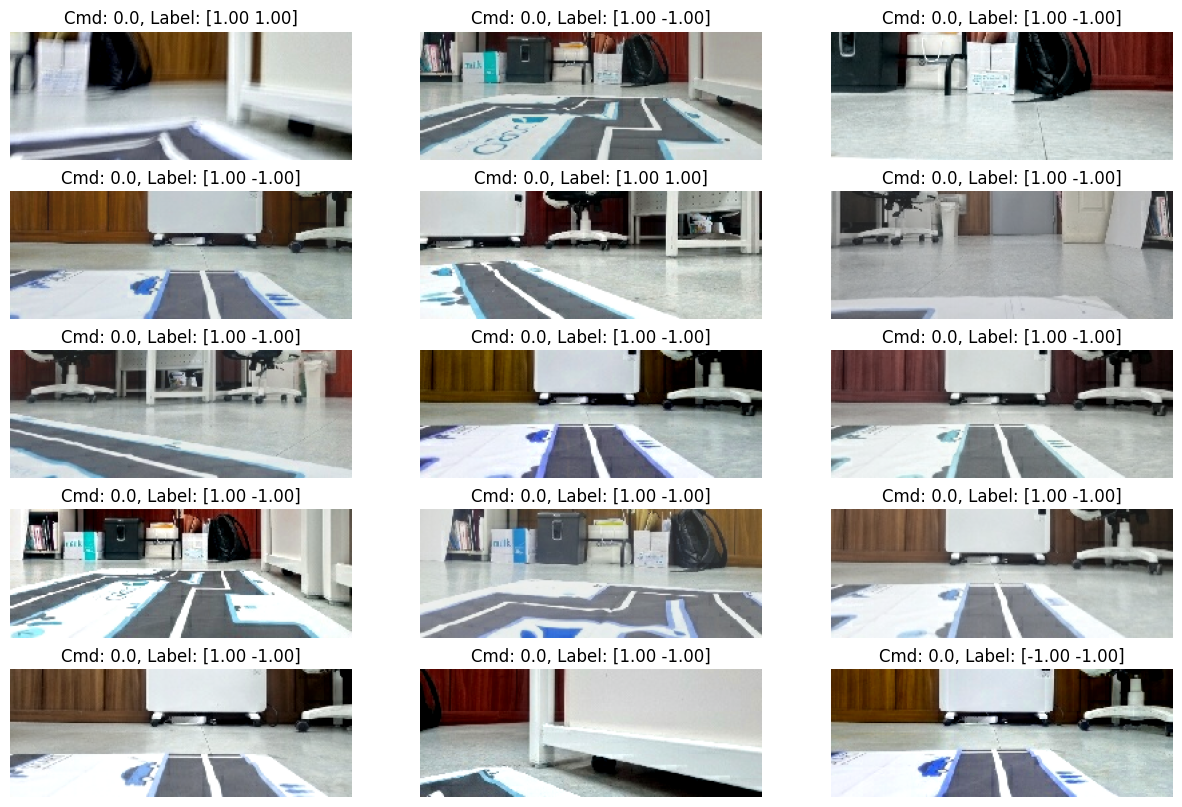

In [18]:
# [한글] 학습 배치 미리보기(가장 견고한 표시 방식)
from openbot import train
import openbot as ob
import os
import IPython.display as ipd  # 모듈로 임포트

# 프리뷰 이미지 생성(저장 경로: /content/OpenBot/policy/models/train_preview.png)
train.visualize_train_data(tr)

preview_path = os.path.join(ob.models_dir, "train_preview.png")
print("preview:", preview_path, "=>", "OK" if os.path.isfile(preview_path) else "없음")
if os.path.isfile(preview_path):
    # IPython의 Image 위젯으로 표시: 백엔드/환경 상관없이 잘 동작
    ipd.display(ipd.Image(filename=preview_path))


# 셀 S — 첫 배치 점검(업데이트, 선택)  ❌
목적 : 배치 텐서 형태/값 범위를 점검하고, 정책별 입력 형상을 안전하게 확인

In [19]:
# [한글] 첫 배치 텐서 형태/값 범위 점검(정합성 체크)
import tensorflow as tf

(image_batch, cmd_batch), label_batch = next(iter(tr.train_ds))

print("image_batch:", image_batch.shape, image_batch.dtype)
print("cmd_batch  :", cmd_batch.shape,  cmd_batch.dtype)   # autopilot: (B,), point_goal_nav: (B,3)
print("label_batch:", label_batch.shape, label_batch.dtype) # (B, 2)

# 값 범위 대략 확인(0~1 또는 -1~1 등)
print("image min/max:", float(tf.reduce_min(image_batch)), float(tf.reduce_max(image_batch)))
print("label min/max:", float(tf.reduce_min(label_batch)), float(tf.reduce_max(label_batch)))

# 정책별 추가 점검
if params.POLICY == "autopilot":
    # cmd는 보통 스칼라(-1~1 근처), label은 [left, right]
    print("cmd_batch 예시(앞 10개):", cmd_batch[:10].numpy())
else:
    # point_goal_nav: [dist, sinYaw, cosYaw]
    print("cmd_batch 예시(앞 3개):", cmd_batch[:3].numpy())


image_batch: (64, 96, 256, 3) <dtype: 'float32'>
cmd_batch  : (64,) <dtype: 'float32'>
label_batch: (64, 2) <dtype: 'float32'>
image min/max: 0.0 1.0
label min/max: -1.0 1.0
cmd_batch 예시(앞 10개): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# 셀 T - 프리뷰/요약 백업(업데이트, 선택) ❌
목적 : 프리뷰 이미지와 실행 요약을 드라이브에 저장해 런타임 종료 후에도 남기기

프리뷰 백업 완료: /content/drive/MyDrive/OpenBotData/run_preview/train_preview.png


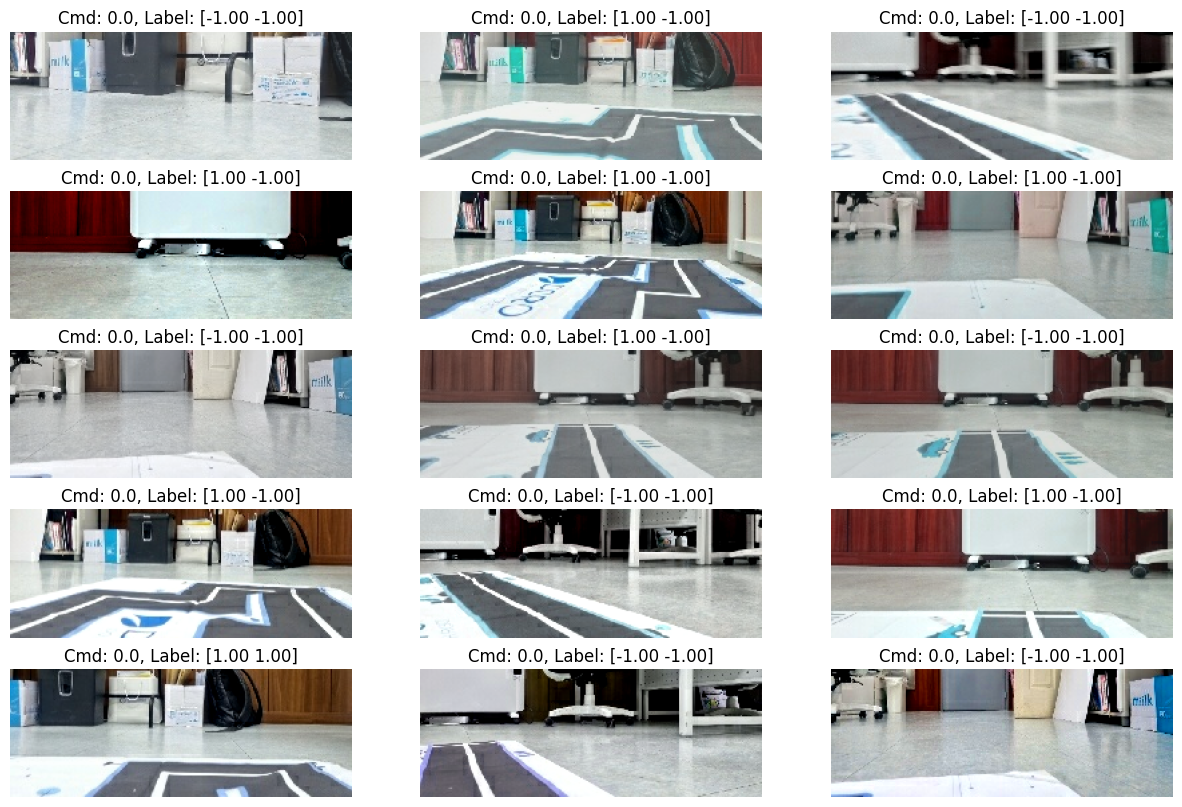

요약 저장 완료: /content/drive/MyDrive/OpenBotData/run_preview/run_summary.json


In [20]:
# [한글] (선택) 프리뷰/요약을 Google Drive에 백업
import os, json, openbot as ob
import IPython.display as ipd

backup_dir = "/content/drive/MyDrive/OpenBotData/run_preview"
os.makedirs(backup_dir, exist_ok=True)

preview_path = os.path.join(ob.models_dir, "train_preview.png")
dst_preview  = os.path.join(backup_dir, "train_preview.png")
if os.path.isfile(preview_path):
    !cp -f "{preview_path}" "{dst_preview}"
    print("프리뷰 백업 완료:", dst_preview)
    ipd.display(ipd.Image(filename=dst_preview))

# 이번 실행 요약 저장
summary = {
    "policy": params.POLICY,
    "model": params.MODEL,
    "epochs": params.NUM_EPOCHS,
    "train_batch": params.TRAIN_BATCH_SIZE,
    "test_batch": params.TEST_BATCH_SIZE,
    "learning_rate": params.LEARNING_RATE,
    "train_images": int(tr.image_count_train),
    "test_images": int(tr.image_count_test),
    "network_img": [int(tr.NETWORK_IMG_HEIGHT), int(tr.NETWORK_IMG_WIDTH)],
}
with open(os.path.join(backup_dir, "run_summary.json"), "w") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)
print("요약 저장 완료:", os.path.join(backup_dir, "run_summary.json"))


# 셀 U - 모델 저장/로그/체크포인트 경로 미리보기  ❌
목적 : 학습 시 결과가 저장될 폴더(체크포인트/로그/모델 구조 이미지) 경로를 미리 확인

In [21]:
# [한글] 학습 결과 저장 경로(체크포인트/로그) 미리보기
import os, openbot as ob
from openbot import train

tmp = train.Training(params)
tmp.model_name = tmp.dataset_name + "_" + str(params)  # train.do_training 내부 계산과 동일
ckpt_path = os.path.join(ob.models_dir, tmp.model_name, "checkpoints")
log_path  = os.path.join(ob.models_dir, tmp.model_name, "logs")
model_png = os.path.join(ob.models_dir, tmp.model_name, "model.png")

print("[저장 경로 미리보기]")
print(" - checkpoint_path:", ckpt_path)
print(" - log_path       :", log_path)
print(" - model.png      :", model_png)


[저장 경로 미리보기]
 - checkpoint_path: /content/OpenBot/policy/models/openbot_pilot_net_lr0.0003_bz64_bn/checkpoints
 - log_path       : /content/OpenBot/policy/models/openbot_pilot_net_lr0.0003_bz64_bn/logs
 - model.png      : /content/OpenBot/policy/models/openbot_pilot_net_lr0.0003_bz64_bn/model.png


# 셀 V - 모델 구조 이미지 의존성 설치(선택) ❌
목적 : plot_model 호출 시 필요한 graphviz/pydot 설치. 설치하지 않으면 학습 초기에 모델 PNG 생성에서 에러가 날 수 있어요.

In [22]:
# [한글] 모델 아키텍처 이미지 저장용 의존성 설치(선택)
# - 설치 안 해도 학습은 가능하지만, train.do_training 내부에서 model.png 생성 시 에러가 날 수 있어 설치 권장
!apt-get -y install graphviz > /dev/null
!pip install -q pydot
print("graphviz/pydot 설치 완료")


graphviz/pydot 설치 완료


# 셀 W — 학습 시작(평가 없이)
목적: openbot.models.create_mlp를 Functional Model로 재정의한 뒤 학습 실행
설명


> 빠른 학습: H → L → Q → W → X(체크) → Y(백업, 선택)

> 처음 데이터셋/환경 점검: H → L → Q → R(1회) → S(필요 시) → W

> 문제가 있을 때만: D1/D2(복구) → Q 재실행

> R/S/U/V/T는 “확인·디버깅·기록”을 위한 보조 셀이라, 상황에 따라 유용합니다.
*   R(배치 미리보기): 학습 전에 샘플 이미지/라벨이 정상인지 눈으로 확인. 새로운 데이터셋을 처음 돌릴 땐 1번 실행 권장.
*   S(첫 배치 텐서 점검): 텐서 shape/값 범위 확인. shape 에러, 라벨 이상(전부 0 등) 의심될 때만 실행.
*  T(프리뷰·요약 드라이브 백업): 런타임 종료돼도 결과를 남기고 싶을 때. 기록/보고용일 때만.
*  U(저장 경로 미리보기): 체크포인트/로그 경로를 명확히 알고 싶을 때. 나중에 파일 찾기 어려울 때 유용.
*  V(model.png 의존성 설치): 모델 구조 이미지를 저장하려면 필요. 구조 PNG가 꼭 필요하지 않으면 생략 가능.

In [23]:
# [한글] 학습 시작(평가 없이) — Keras3 완전 호환(체크포인트 .keras + Functional MLP + 손실/steps 패치)
import os, sys, importlib, tensorflow as tf, numpy as _np
if "/content/OpenBot/policy" not in sys.path:
    sys.path.insert(0, "/content/OpenBot/policy"); importlib.invalidate_caches()

from openbot import train
import openbot.models as models
import openbot.callbacks as cbs
import openbot.losses as losses

# 1) MLP를 Functional Model로 패치(Keras3에서 .input/.output 접근 오류 방지)
def _create_mlp(in_dim, hidden_dim, out_dim, activation="relu", dropout=0.2, name="cmd"):
    inputs = tf.keras.Input(shape=(in_dim,), name=f"{name}_input")
    x = tf.keras.layers.Dense(hidden_dim, activation=activation, name=name)(inputs)
    if dropout > 0:
        x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(out_dim, activation=activation)(x)
    return tf.keras.Model(inputs, outputs, name="MLP")
models.create_mlp = _create_mlp

# 2) ModelCheckpoint(.keras 확장자) 패치
def _ckpt(path, fname, monitor, best):
    os.makedirs(path, exist_ok=True)
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(path, fname),
        monitor=monitor,
        verbose=0,
        save_best_only=best,
        save_weights_only=False,
        mode="auto",
        save_freq="epoch",
    )
cbs.checkpoint_cb            = lambda p, **k: _ckpt(p, "cp-{epoch:04d}.keras", "val_loss", False)
cbs.checkpoint_last_cb       = lambda p, **k: _ckpt(p, "cp-last.keras", "val_loss", False)
cbs.checkpoint_best_train_cb = lambda p, **k: _ckpt(p, "cp-best-train.keras", "loss", True)
cbs.checkpoint_best_val_cb   = lambda p, **k: _ckpt(p, "cp-best-val.keras", "val_loss", True)

# 3) 손실함수 Keras3 호환 패치(원래 losses.py가 mean_squared_error/mean_absolute_error 심볼을 사용)
def _mse(a, b):  # (B, ...) -> (B,)
    return tf.reduce_mean(tf.square(a - b), axis=-1)
def _mae(a, b):
    return tf.reduce_mean(tf.abs(a - b), axis=-1)
def _angle(y):
    return y[:, 1] - y[:, 0]   # losses.py 끝부분 정의와 일관

losses.mse_raw  = lambda y_gt, y_pred: _mse(y_gt, y_pred)
losses.mae_raw  = lambda y_gt, y_pred: _mae(y_gt, y_pred)
losses.mse_angle = lambda y_gt, y_pred: _mse(_angle(y_gt), _angle(y_pred))

def _sq_weighted_mse_angle(y_true, y_pred):
    angle_true = y_true[:, 1] - y_true[:, 0]
    angle_pred = y_pred[:, 1] - y_pred[:, 0]
    weight = tf.abs(angle_true + 0.05)
    return tf.square(weight) * (_mse(angle_true, angle_pred) + _mse(y_true, y_pred))
losses.sq_weighted_mse_angle = _sq_weighted_mse_angle

# 4) steps_per_epoch 정수화(keras 3 요구). do_training 내부 np.ceil을 일시적으로 정수 반환으로 패치
_orig_ceil = _np.ceil
train.np.ceil = lambda v, _f=_orig_ceil: int(_f(v))

# 5) tr/cb 확인
try:
    tr
except NameError:
    raise RuntimeError("tr가 없습니다. 바로 위 '데이터셋 로드'(셀 Q)를 먼저 실행하세요.")
try:
    cb
except NameError:
    import threading
    cb = train.MyCallback(lambda e,p=None: print(e,p), threading.Event(), show_progress=True)

# 6) 학습
print("학습 시작...")
try:
    train.do_training(tr, cb, verbose=1)
finally:
    train.np.ceil = _orig_ceil  # 원복

print("\n[학습 완료]")
print("checkpoint_path:", tr.checkpoint_path)
print("log_path       :", tr.log_path)


학습 시작...
model openbot_pilot_net_lr0.0003_bz64_bn


Model: "pilot_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 96, 256,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 46, 126,   │      1,824 │ img_input[0][0]   │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 46, 126,   │         96 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 21, 61,    │     21,636 │ batch_normalizat… │
│                     │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 61,    │        144 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 36)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 9, 29, 48) │     43,248 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 9, 29, 48) │        192 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 7, 27, 64) │     27,712 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 27, 64) │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 5, 25, 64) │     36,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 25, 64) │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 8000)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1164)      │  9,313,164 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmd_input           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1164)      │      4,656 │ dense_19[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cmd (Dense)         │ (None, 1)         │          2 │ cmd_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 100)       │    116,500 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1)         │          2 │ cmd[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_20[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 9,572,660 (36.52 MB)

 Trainable params: 9,569,660 (36.51 MB)

 Non-trainable params: 3,000 (11.72 KB)

None
openbot_pilot_net_lr0.0003_bz64_bn
message Fit model...
Epoch 1/5
progress {'epoch': 9.1, 'train': 1.8}
 1/11 ━━━━━━━━━━━━━━━━━━━━ 2:41 16s/step - angle_metric: 0.0000e+00 - direction_metric: 0.5156 - loss: 8.6733 - mean_absolute_error: 0.9543progress {'epoch': 18.2, 'train': 3.6}
 2/11 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - angle_metric: 0.0117 - direction_metric: 0.5078 - loss: 8.7242 - mean_absolute_error: 0.9678    progress {'epoch': 27.3, 'train': 5.5}
progress {'epoch': 36.4, 'train': 7.3}
 4/11 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - angle_metric: 0.0231 - direction_metric: 0.5186 - loss: 8.4936 - mean_absolute_error: 0.9722 progress {'epoch': 45.5, 'train': 9.1}
 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - angle_metric: 0.0285 - direction_metric: 0.5236 - loss: 8.3763 - mean_absolute_error: 0.9701progress {'epoch': 54.5, 'train': 10.9}
 6/11 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - angle_metric: 0.0333 - direction_metric: 0.5270 - loss: 8.2513 - mean_absolute_error: 0.9639progress {'epo

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


on_epoch_end {'angle_metric': 0.07386363297700882, 'direction_metric': 0.546875, 'loss': 5.640397071838379, 'mean_absolute_error': 0.8768382668495178, 'val_angle_metric': 0.6113861203193665, 'val_direction_metric': 1.0, 'val_loss': 4.741568565368652, 'val_mean_absolute_error': 0.9943552017211914, 'epoch': 0}
logs {'angle_metric': 0.07386363297700882, 'direction_metric': 0.546875, 'loss': 5.640397071838379, 'mean_absolute_error': 0.8768382668495178, 'val_angle_metric': 0.6113861203193665, 'val_direction_metric': 1.0, 'val_loss': 4.741568565368652, 'val_mean_absolute_error': 0.9943552017211914, 'epoch': 0}
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 658ms/step - angle_metric: 0.0739 - direction_metric: 0.5469 - loss: 5.6404 - mean_absolute_error: 0.8768 - val_angle_metric: 0.6114 - val_direction_metric: 1.0000 - val_loss: 4.7416 - val_mean_absolute_error: 0.9944
Epoch 2/5
progress {'epoch': 9.1, 'train': 21.8}
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - angle_metric: 0.1875 - direction_metric: 0.5469 -

# Evaluation

The loss and mean absolute error should decrease. This indicates that the model is fitting the data well. The custom metrics (direction and angle) should go towards 1. These provide some additional insight to the training progress. The direction metric measures weather or not predictions are in the same direction as the labels. Similarly the angle metric measures if the prediction is within a small angle of the labels. The intuition is that driving in the right direction with the correct steering angle is most critical part for good final performance.

### Plot metrics

In [ ]:
x = np.arange(tr.INITIAL_EPOCH + 1, tr.history.params["epochs"] + 1, 1)

In [ ]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["loss"], label="loss")
plt.plot(x, tr.history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig(os.path.join(tr.log_path, "loss.png"), bbox_inches="tight")

In [ ]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["mean_absolute_error"], label="mean_absolute_error")
plt.plot(
    x, tr.history.history["val_mean_absolute_error"], label="val_mean_absolute_error"
)
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend(loc="upper right")
plt.savefig(os.path.join(tr.log_path, "error.png"), bbox_inches="tight")

In [ ]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["direction_metric"], label="direction_metric")
plt.plot(x, tr.history.history["val_direction_metric"], label="val_direction_metric")
plt.xlabel("Epoch")
plt.ylabel("Direction Metric")
plt.legend(loc="lower right")
plt.savefig(os.path.join(tr.log_path, "direction.png"), bbox_inches="tight")

In [ ]:
plt.figure().gca().xaxis.get_major_locator().set_params(integer=True)
plt.plot(x, tr.history.history["angle_metric"], label="angle_metric")
plt.plot(x, tr.history.history["val_angle_metric"], label="val_angle_metric")
plt.xlabel("Epoch")
plt.ylabel("Angle Metric")
plt.legend(loc="lower right")
plt.savefig(os.path.join(tr.log_path, "angle.png"), bbox_inches="tight")

### Save tf lite models for best train, best val and last checkpoint

In [ ]:
best_train_checkpoint = "cp-best-train.ckpt"
best_train_tflite = utils.generate_tflite(tr.checkpoint_path, best_train_checkpoint)
utils.save_tflite(best_train_tflite, tr.checkpoint_path, "best-train")
best_train_index = np.argmin(np.array(tr.history.history["loss"]))
print(
    "Best Train Checkpoint (epoch %s) - angle: %.4f, val_angle: %.4f, direction: %.4f, val_direction: %.4f"
    % (
        best_train_index,
        tr.history.history["angle_metric"][best_train_index],
        tr.history.history["val_angle_metric"][best_train_index],
        tr.history.history["direction_metric"][best_train_index],
        tr.history.history["val_direction_metric"][best_train_index],
    )
)

In [ ]:
best_val_checkpoint = "cp-best-val.ckpt"
best_val_tflite = utils.generate_tflite(tr.checkpoint_path, best_val_checkpoint)
utils.save_tflite(best_val_tflite, tr.checkpoint_path, "best")
utils.save_tflite(best_val_tflite, tr.checkpoint_path, "best-val")
best_val_index = np.argmin(np.array(tr.history.history["val_loss"]))
print(
    "Best Val Checkpoint (epoch %s) - angle: %.4f, val_angle: %.4f, direction: %.4f, val_direction: %.4f"
    % (
        best_val_index,
        tr.history.history["angle_metric"][best_val_index],
        tr.history.history["val_angle_metric"][best_val_index],
        tr.history.history["direction_metric"][best_val_index],
        tr.history.history["val_direction_metric"][best_val_index],
    )
)

In [ ]:
last_checkpoint = "cp-last.ckpt"
last_tflite = utils.generate_tflite(tr.checkpoint_path, last_checkpoint)
utils.save_tflite(last_tflite, tr.checkpoint_path, "last")
print(
    "Last Checkpoint - angle: %.4f, val_angle: %.4f, direction: %.4f, val_direction: %.4f"
    % (
        tr.history.history["angle_metric"][-1],
        tr.history.history["val_angle_metric"][-1],
        tr.history.history["direction_metric"][-1],
        tr.history.history["val_direction_metric"][-1],
    )
)

### Evaluate the best model (train loss) on the training set

In [ ]:
best_train_model = utils.load_model(
    os.path.join(tr.checkpoint_path, best_train_checkpoint),
    tr.loss_fn,
    tr.metric_list,
    tr.custom_objects,
)
loss, mae, direction, angle = best_train_model.evaluate(
    tr.train_ds,
    steps=tr.image_count_train / tr.hyperparameters.TRAIN_BATCH_SIZE,
    verbose=1,
)

In [ ]:
utils.show_batch(
    dataset=tr.train_ds, policy=tr.hyperparameters.POLICY, model=best_train_model
)

In [ ]:
utils.compare_tf_tflite(best_train_model, best_train_tflite)

### Evaluate the best model (val loss) on the validation set

In [ ]:
best_val_model = utils.load_model(
    os.path.join(tr.checkpoint_path, best_val_checkpoint),
    tr.loss_fn,
    tr.metric_list,
    tr.custom_objects,
)
loss, mae, direction, angle = best_val_model.evaluate(
    tr.test_ds,
    steps=tr.image_count_test / tr.hyperparameters.TEST_BATCH_SIZE,
    verbose=1,
)

In [ ]:
utils.show_batch(
    dataset=tr.test_ds, policy=tr.hyperparameters.POLICY, model=best_val_model
)

In [ ]:
utils.compare_tf_tflite(best_val_model, best_val_tflite)

# Save the notebook as HTML

In [ ]:
utils.save_notebook()
current_file = "policy_learning.ipynb"
output_file = os.path.join(tr.log_path, "notebook.html")
utils.output_HTML(current_file, output_file)